# SSD7 Inferencing Tutorial

This tutorial explains how to train an SSD7 on the Udacity road traffic datasets, and just generally how to use this SSD implementation.

Disclaimer about SSD7:
As you will see below, training SSD7 on the aforementioned datasets yields alright results, but I'd like to emphasize that SSD7 is not a carefully optimized network architecture. The idea was just to build a low-complexity network that is fast (roughly 127 FPS or more than 3 times as fast as SSD300 on a GTX 1070) for testing purposes. Would slightly different anchor box scaling factors or a slightly different number of filters in individual convolution layers make SSD7 significantly better at similar complexity? I don't know, I haven't tried.

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

%matplotlib inline

Using TensorFlow backend.


## 1. Set the model configuration parameters

The cell below sets a number of parameters that define the model configuration. The parameters set here are being used both by the `build_model()` function that builds the model as well as further down by the constructor for the `SSDInputEncoder` object that is needed to to match ground truth and anchor boxes during the training.

Here are just some comments on a few of the parameters, read the documentation for more details:

* Set the height, width, and number of color channels to whatever you want the model to accept as image input. If your input images have a different size than you define as the model input here, or if your images have non-uniform size, then you must use the data generator's image transformations (resizing and/or cropping) so that your images end up having the required input size before they are fed to the model. to convert your images to the model input size during training. The SSD300 training tutorial uses the same image pre-processing and data augmentation as the original Caffe implementation, so take a look at that to see one possibility of how to deal with non-uniform-size images.
* The number of classes is the number of positive classes in your dataset, e.g. 20 for Pascal VOC or 80 for MS COCO. Class ID 0 must always be reserved for the background class, i.e. your positive classes must have positive integers as their IDs in your dataset.
* The `mode` argument in the `build_model()` function determines whether the model will be built with or without a `DecodeDetections` layer as its last layer. In 'training' mode, the model outputs the raw prediction tensor, while in 'inference' and 'inference_fast' modes, the raw predictions are being decoded into absolute coordinates and filtered via confidence thresholding, non-maximum suppression, and top-k filtering. The difference between latter two modes is that 'inference' uses the decoding procedure of the original Caffe implementation, while 'inference_fast' uses a faster, but possibly less accurate decoding procedure.
* The reason why the list of scaling factors has 5 elements even though there are only 4 predictor layers in tSSD7 is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. Refer to the documentation for details.
* `build_model()` and `SSDInputEncoder` have two arguments for the anchor box aspect ratios: `aspect_ratios_global` and `aspect_ratios_per_layer`. You can use either of the two, you don't need to set both. If you use `aspect_ratios_global`, then you pass one list of aspect ratios and these aspect ratios will be used for all predictor layers. Every aspect ratio you want to include must be listed once and only once. If you use `aspect_ratios_per_layer`, then you pass a nested list containing lists of aspect ratios for each individual predictor layer. This is what the SSD300 training tutorial does. It's your design choice whether all predictor layers should use the same aspect ratios or whether you think that for your dataset, certain aspect ratios are only necessary for some predictor layers but not for others. Of course more aspect ratios means more predicted boxes, which in turn means increased computational complexity.
* If `two_boxes_for_ar1 == True`, then each predictor layer will predict two boxes with aspect ratio one, one a bit smaller, the other one a bit larger.
* If `clip_boxes == True`, then the anchor boxes will be clipped so that they lie entirely within the image boundaries. It is recommended not to clip the boxes. The anchor boxes form the reference frame for the localization prediction. This reference frame should be the same at every spatial position.
* In the matching process during the training, the anchor box offsets are being divided by the variances. Leaving them at 1.0 for each of the four box coordinates means that they have no effect. Setting them to less than 1.0 spreads the imagined anchor box offset distribution for the respective box coordinate.
* `normalize_coords` converts all coordinates from absolute coordinate to coordinates that are relative to the image height and width. This setting has no effect on the outcome of the training.

In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model

If you want to create a new model, this is the relevant section for you. If you want to load a previously saved model, skip ahead to section 2.2.

The code cell below does the following things:
1. It calls the function `build_model()` to build the model.
2. It optionally loads some weights into the model.
3. It then compiles the model for the training. In order to do so, we're defining an optimizer (Adam) and a loss function (SSDLoss) to be passed to the `compile()` method.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper.

In [3]:
pass

### 2.2 Load a saved model

If you have previously created and saved a model and would now like to load it, simply execute the next code cell. The only thing you need to do is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function, nor the anchor box or detection decoding layer types are contained in the Keras core library, so we need to provide them to the model loader.

This next code cell assumes that you want to load a model that was created in 'training' mode. If you want to load a model that was created in 'inference' or 'inference_fast' mode, you'll have to add the `DecodeDetections` or `DecodeDetectionsFast` layer type to the `custom_objects` dictionary below.

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7_epoch-16_loss-2.1683_val_loss-2.3226.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

## 3 Load some images
load some images for which you'd like to run prediction

In [8]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'examples/1479500479608176480.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

## 4. Make predictions

In [9]:
# 3: Make a prediction

y_pred = model.predict(input_images)

Now let's decode the raw predictions in `y_pred`.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.

In [12]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.35,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.    69.97 135.55  93.16 153.21]
 [  1.     0.99 181.75 137.78 206.27 155.61]
 [  1.     0.98 114.22 133.29 136.37 151.71]
 [  1.     0.93 237.8  137.88 260.73 154.43]
 [  1.     0.81 220.79 137.55 239.37 150.73]
 [  1.     0.78  -3.73 138.2   29.28 168.28]
 [  2.     0.96 173.85 115.16 205.66 153.3 ]
 [  2.     0.86 300.99  95.5  451.78 194.06]
 [  2.     0.69 181.71 123.39 199.21 145.6 ]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

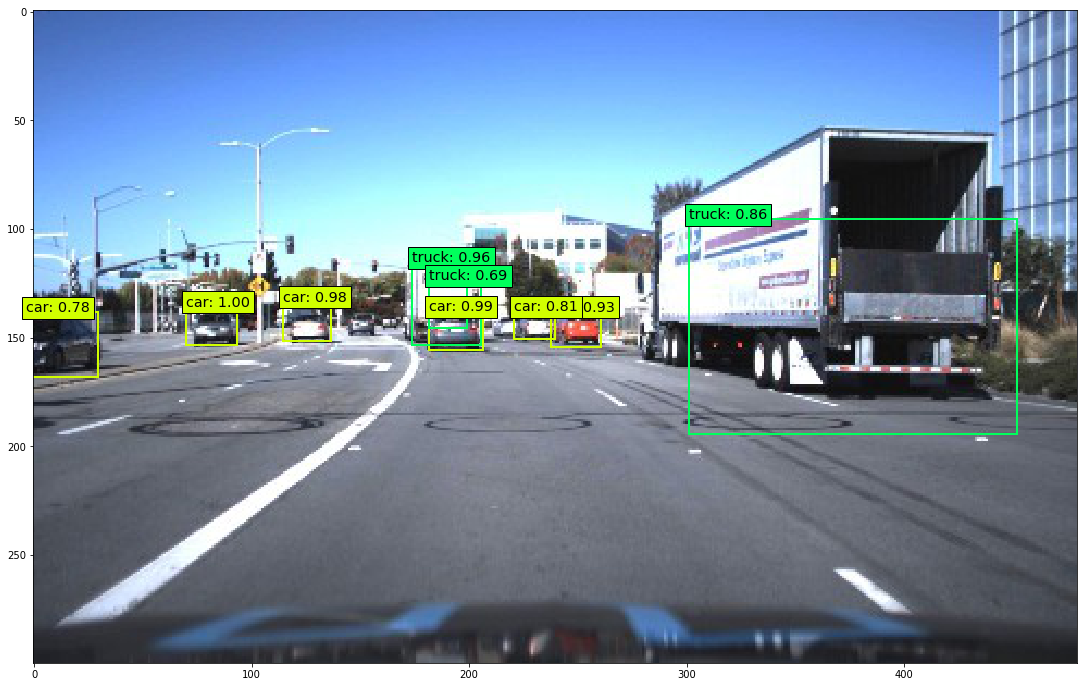

In [13]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs


# Draw the predicted boxes in blue
for box in y_pred_decoded[0]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='black', bbox={'facecolor':color, 'alpha':1.0})